* We want to investigate how representations obtained from different layers of Bert can contribute to Homogenization in content recommenders.
* To do this we analyze the average cosine similarity between topic independant keywords and topic specific keywords that are indicative of a particular stance (ie either conservative or liberal)
* If the average cosine similarity of a particular layer is very high then it is an indication that the representations obtained from this layer can contribute to the homogenization effect in content recommenders
    * if topic specific and topic independant word representations have high cosine similarity based on which layer the representations were obtained from then it can indicate that:
        * When the recommendation system is trained on a specific topic and learns the user's preference for this by assigning large weights for keywords/dims that are indicative of the stance that the user prefers for the current topic, when a new topic arrives and the user's preference for this topic is not the same as the previous topic the system was trained on then the large weights can force the classifier to recommend items that are of different partisan stance to whhat the user prefers for this topic but is similar to the stance the user prefers on the original topic the system was first trained on.

In [1]:
%config Completer.use_jedi = False

In [2]:
import torch
import pickle
from transformers import BertModel, BertTokenizer
from general_utils import timer
import os
import numpy as np
from bert_utils import load_model, load_tokenizer, batch_text_gen
import torch
from collections import defaultdict
import itertools
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

....... Initializing Settings ..... 
Random_Seed Chosen : 15112


In [3]:
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['axes.grid'] = False

In [4]:
def load_txt(filename):
    """
    """
    word_list = []
    with open(filename,'r') as rp:
        word_list = rp.readlines()
    
    word_list = list(set([w.strip() for w in word_list]))
    print("Loaded file : %s" %filename)
    print("Num Keywords : %s" %str(len(word_list)))
    
    return word_list

def tokenize_bert_single_token(token_batch,tokenizer,debug_flag=False):
    """
    """
    encoded_batch = []
    for token in token_batch:
        encoded_token = tokenizer.encode(token,add_special_tokens=False,padding="max_length",max_length=10) # padding is longest because subwords exist in the vocab so the tokenizer splits a given word into subwords
        if debug_flag:
            print(token)
            print(tokenizer.convert_ids_to_tokens(encoded_token))
        encoded_batch.append(encoded_token)
    
    tokenized_batch = torch.LongTensor(encoded_batch)
    tokenized_tensor = tokenized_batch.to('cuda')
    return tokenized_tensor, encoded_batch


def combine_subwords(hidden_state,token_ids):
    """
    hidden_state_shape = (maxlength_padding,768)
    
    choose token_ids that are not 0
    
    """
    subword_arrs = []
    for t_i,t in enumerate(token_ids):
        if t != 0:
            subword_arrs.append(hidden_state[t_i,:])
    
    return np.mean(subword_arrs,axis=0).reshape(1,-1)

def get_kw_bert_rep(kw_list,layer_map,bert_tokenizer,bert_model,bs=10):
    """
    """
    batch_count = 0
    for kw_batch in batch_text_gen(kw_list,batch_size = bs):
        print("Batch No : %s" %str(batch_count))
        tokenized_kw_batch, encoded_batch_ids = tokenize_bert_single_token(kw_batch,bert_tokenizer)
        batch_out = bert_model(input_ids=tokenized_kw_batch)
        batch_hidden_states = batch_out[2] # 13 layers as layer(0) is input to the transformer 
        
        for layer_ind in range(13):
            for t_id, token in enumerate(kw_batch):
                token_hidden_state = batch_hidden_states[layer_ind][t_id,:,:].cpu().detach().numpy()
                # index here to drop the pad tokens and only consider the actual word representation (if subwords then avg the subwords to get word representation) (PAD has token id of 0)
                token_hidden_state = combine_subwords(token_hidden_state,encoded_batch_ids[t_id])
                layer_map[token]["layer_%s"%str(layer_ind)] = token_hidden_state
        batch_count+=1     

def get_batch_size(kw_list,ratio=10):
    """
    """
    batch_size = int(len(kw_list)/ratio)
    
    if len(kw_list) <=25:
        batch_size = len(kw_list)
    
    return batch_size

def compare_bert_rep_token(kw_topic_specific,kw_topic_indep):
    """
    """
    bert_mod = load_model()
    bert_tok = load_tokenizer()
    
    bert_map = defaultdict(lambda :defaultdict())
    
    # topic specific keywords
    print("Getting bert representation for Topic Specific Keywords ... \n")
    batch_size = get_batch_size(kw_topic_specific)
    
    get_kw_bert_rep(kw_list=kw_topic_specific,
                    layer_map=bert_map,
                    bert_tokenizer=bert_tok,
                    bert_model=bert_mod,
                    bs=batch_size)
    
    # topic indep keywords
    print("Getting bert representation for Topic Independent Keywords ... \n")
    batch_size = get_batch_size(kw_topic_indep)
    
    get_kw_bert_rep(kw_list=kw_topic_indep,
                    layer_map=bert_map,
                    bert_tokenizer=bert_tok,
                    bert_model=bert_mod,
                    bs=batch_size)
    
    # cosin_sim
    cosine_sims_layer_map = defaultdict(list)
    for wp in itertools.product(kw_topic_indep,kw_topic_specific):
        for layer_id in range(13):
            cos_sim = cosine_similarity(bert_map[wp[0]]["layer_%s"%str(layer_id)],bert_map[wp[1]]["layer_%s"%str(layer_id)])
            cosine_sims_layer_map[layer_id].append(cos_sim)
    
    # avg
    avg_scores = []
    for layer in sorted(cosine_sims_layer_map.keys()):
        avg_scores.append(np.mean(cosine_sims_layer_map[layer]))
    
    # plot
    fig,ax = plt.subplots(1,1,figsize=(10,8))
    ax.scatter(range(13),avg_scores,s=100)
    ax.set_xlabel("Bert Layers")
    ax.set_ylabel("Avg Cosine Similarity")
    ax.set_xticks(range(-1,13,1))
    ax.set_xlim(-1,13)
    ax.set_ylim(0.0,1.0)
    sns.regplot(x=[i for i in range(13)], y=avg_scores,ax=ax,color="cornflowerblue")
    plt.title("Average Cosine Similarity between Topic Independant Keywords and Topic Specific Keywords\n for Representations from different Layers of BERT")
    plt.grid(True, linestyle='--')
    plt.tight_layout()
    plt.show()
    return bert_map

In [5]:
# conservative keyword paths
conserv_topic_indep_kw_path = "Files/Keyword_Lists/Topic_Independant_keywords_Conservative.txt"
conserv_topic_spec_kw_path = "Files/Keyword_Lists/Topic_Specific_keywords_conservative.txt"
# liberal keyword paths
liberal_topic_indep_kw_path = "Files/Keyword_Lists/Topic_independant_keywords_liberals.txt"
liberal_topic_spec_kw_path = "Files/Keyword_Lists/Topic_Specific_keywords_liberal.txt"

In [6]:
conserv_topic_indep_kw = load_txt(conserv_topic_indep_kw_path)
conserv_topic_spec_kw = load_txt(conserv_topic_spec_kw_path)
liberal_topic_indep_kw = load_txt(liberal_topic_indep_kw_path)
liberal_topic_spec_kw = load_txt(liberal_topic_spec_kw_path)

Loaded file : Files/Keyword_Lists/Topic_Independant_keywords_Conservative.txt
Num Keywords : 18
Loaded file : Files/Keyword_Lists/Topic_Specific_keywords_conservative.txt
Num Keywords : 184
Loaded file : Files/Keyword_Lists/Topic_independant_keywords_liberals.txt
Num Keywords : 21
Loaded file : Files/Keyword_Lists/Topic_Specific_keywords_liberal.txt
Num Keywords : 180


In [7]:
print(set(conserv_topic_indep_kw).intersection(liberal_topic_indep_kw))
print(set(conserv_topic_indep_kw).intersection(conserv_topic_spec_kw))
print(set(liberal_topic_indep_kw).intersection(liberal_topic_spec_kw))
print(set(conserv_topic_spec_kw).intersection(liberal_topic_spec_kw))

set()
set()
set()
{'morality', 'impeachable', 'propelled', 'expectancy', 'implication', 'socialite', 'regulator', 'capitalist', 'betrayal', 'christians', 'retaliate', 'estranged', 'trooper', 'positioning', 'supremacy', 'penalty', 'unfit', 'mandates', 'pessimistic', 'capitalize', 'pardons', 'grueling', 'impede', 'severity', 'punishments', 'impoverished', 'crackdown', 'extremists'}


## Conservative Keywords Comparison

Getting bert representation for Topic Specific Keywords ... 

Batch No : 0
Batch No : 1
Batch No : 2
Batch No : 3
Batch No : 4
Batch No : 5
Batch No : 6
Batch No : 7
Batch No : 8
Batch No : 9
Batch No : 10
Getting bert representation for Topic Independent Keywords ... 

Batch No : 0


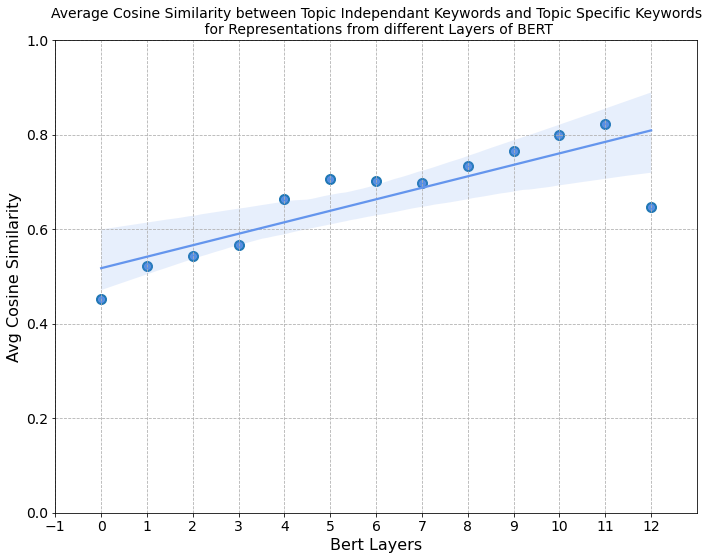

In [8]:
layer_map = compare_bert_rep_token(kw_topic_specific=conserv_topic_spec_kw,
                                   kw_topic_indep=conserv_topic_indep_kw)

## Liberal Keywords Comparison

Getting bert representation for Topic Specific Keywords ... 

Batch No : 0
Batch No : 1
Batch No : 2
Batch No : 3
Batch No : 4
Batch No : 5
Batch No : 6
Batch No : 7
Batch No : 8
Batch No : 9
Getting bert representation for Topic Independent Keywords ... 

Batch No : 0


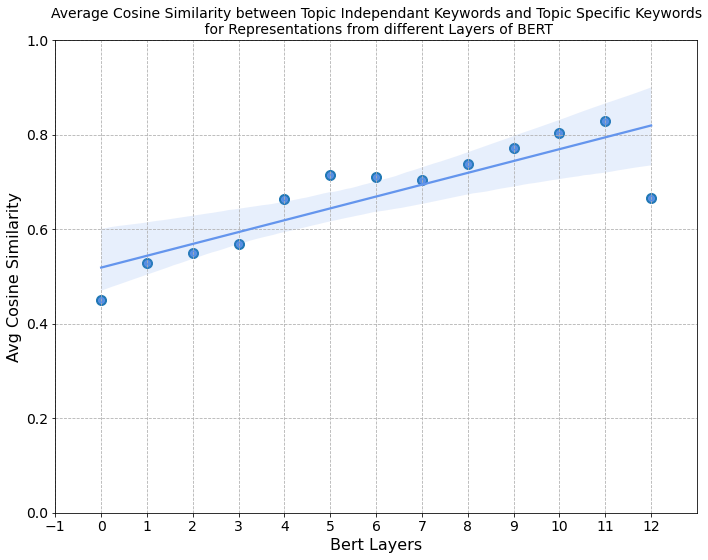

In [9]:
layer_map = compare_bert_rep_token(kw_topic_specific=liberal_topic_spec_kw,
                                   kw_topic_indep=liberal_topic_indep_kw)